In [20]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from matplotlib import cm as CM
from matplotlib.colors import LogNorm
cmap = CM.get_cmap('jet') 
cmap.set_bad('w') 

def get_h5keys(i,k0,dat):
    kk = k0
    try:       
        for k in dat.keys():
            kk = k0+'/'+k
            print(kk)
            get_h5keys(i+1,kk,dat[k])
    except Exception as e:
        pass

def plot2d(mat,bxax,byax,title,xlabel,ylabel,ast,figsz = None):
    if figsz!=None:
        fig = plt.figure(figsize=figsz)
    else:
        fig = plt.gcf()

    im=plt.imshow(np.rot90(mat),interpolation="nearest", cmap=cmap,
                  norm=LogNorm(vmin=1, vmax=mat.max()),
                  extent = [bxax.min(),bxax.max(),byax.min(),byax.max()],
                  aspect=ast*(bxax.min()-bxax.max())/(byax.min()-byax.max()))

    plt.colorbar(im,fraction=0.046, pad=0.04)   

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)    

### Preprocessed data file location

In [3]:
ls /gpfs/exfel/exp/SQS/202121/p002926/proc/

r0004/  r0015/  r0016/  r0032/  r0051/  r0052/


In [4]:
ls /gpfs/exfel/exp/SQS/202121/p002926/proc/r0052

CORR-R0052-DA05-S00000.h5  CORR-R0052-DA05-S00002.h5
CORR-R0052-DA05-S00001.h5  CORR-R0052-DA05-S00003.h5


### Read a data file

In [9]:
run = 'r0052'
dat_dir = '/gpfs/exfel/exp/SQS/202121/p002926/proc/'+run+'/'
datf = h5py.File(dat_dir+'CORR-R0052-DA05-S00003.h5','r')

### Check the data file structure

In [10]:
get_h5keys(0,'',datf)

/CONTROL
/CONTROL/SQS_REMI_DLD6
/CONTROL/SQS_REMI_DLD6/DET
/CONTROL/SQS_REMI_DLD6/DET/TOP
/INDEX
/INDEX/SQS_REMI_DLD6
/INDEX/SQS_REMI_DLD6/DET
/INDEX/SQS_REMI_DLD6/DET/TOP:output
/INDEX/SQS_REMI_DLD6/DET/TOP:output/raw
/INDEX/SQS_REMI_DLD6/DET/TOP:output/raw/count
/INDEX/SQS_REMI_DLD6/DET/TOP:output/raw/first
/INDEX/SQS_REMI_DLD6/DET/TOP:output/rec
/INDEX/SQS_REMI_DLD6/DET/TOP:output/rec/count
/INDEX/SQS_REMI_DLD6/DET/TOP:output/rec/first
/INDEX/flag
/INDEX/trainId
/INSTRUMENT
/INSTRUMENT/SQS_REMI_DLD6
/INSTRUMENT/SQS_REMI_DLD6/DET
/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output
/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output/raw
/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output/raw/edges
/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output/rec
/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output/rec/hits
/METADATA
/METADATA/creationDate
/METADATA/daqLibrary
/METADATA/dataFormatVersion
/METADATA/dataSources
/METADATA/dataSources/dataSourceId
/METADATA/dataSources/deviceId
/METADATA/dataSources/root
/METADATA/karaboFramework
/METADA

### Get Hits (x,y,t) over many shots

In [11]:
hits = datf['/INSTRUMENT/SQS_REMI_DLD6/DET/TOP:output/rec/hits']
ts = hits['t']
ts_ind = ~np.isnan(ts)
ts = ts[ts_ind]
xs = hits['x'][ts_ind]
ys = hits['y'][ts_ind]

### Count rate

<IPython.core.display.Javascript object>


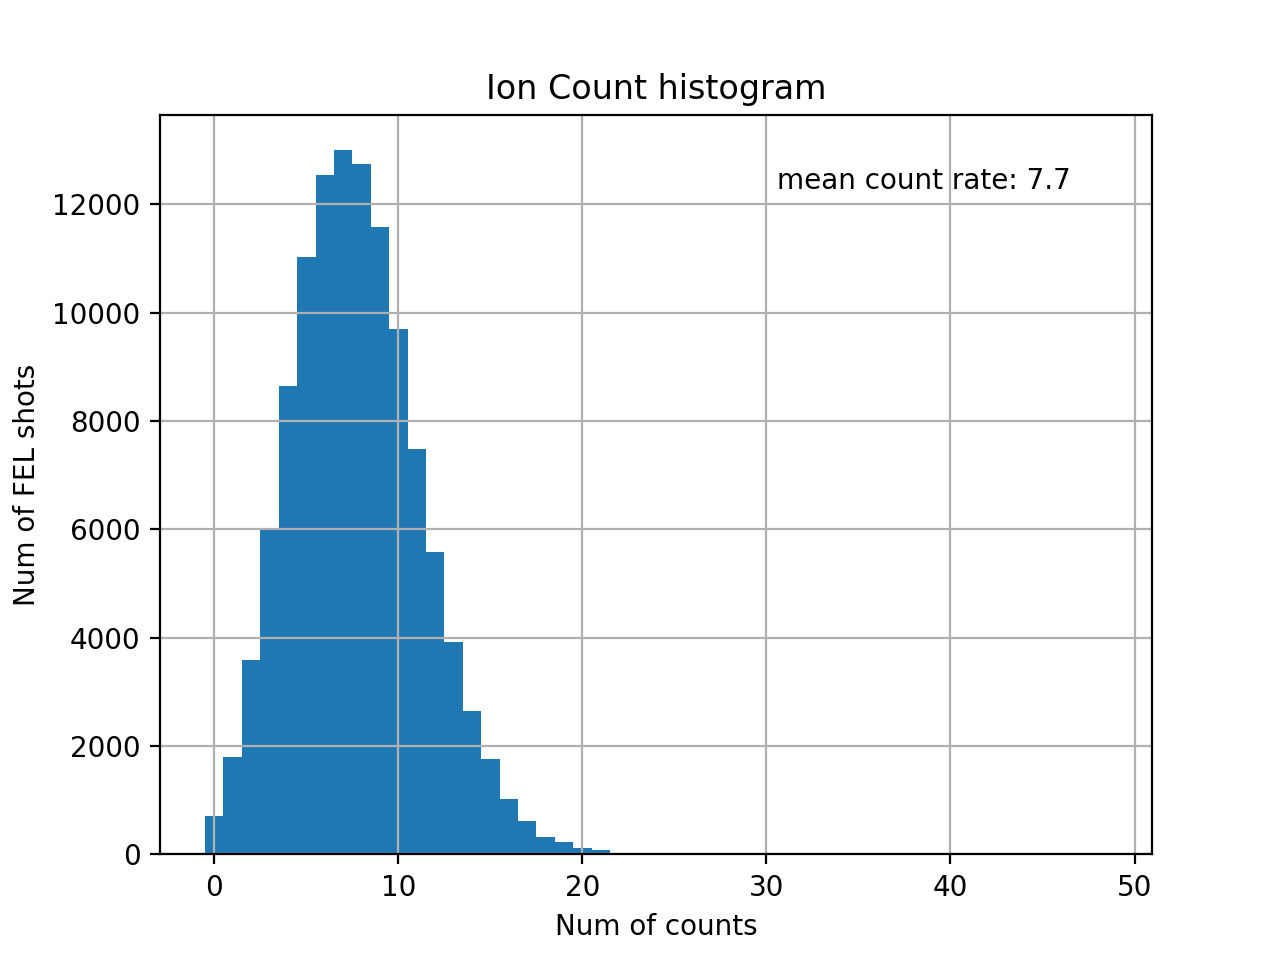

Text(0, 0.5, 'Num of FEL shots')

In [12]:
num_hits = ts_ind.sum(1)
numhits_bins = np.arange(50)-0.5
plt.figure()
plt.hist(num_hits,numhits_bins)
plt.grid('on')
plt.text(s = 'mean count rate: '+str(round(np.mean(num_hits),1)),x=0.6*plt.xlim()[1],y=0.9*plt.ylim()[1])
plt.title('Ion Count histogram')
plt.xlabel('Num of counts')
plt.ylabel('Num of FEL shots')

### X-Y-T & PiPiCo

In [14]:
tbins = np.arange(0,5300,3)
xbins = np.arange(-150,150,1)
th1 = (tbins[1:]+tbins[:-1])/2
xh1 = (xbins[1:]+xbins[:-1])/2


<IPython.core.display.Javascript object>


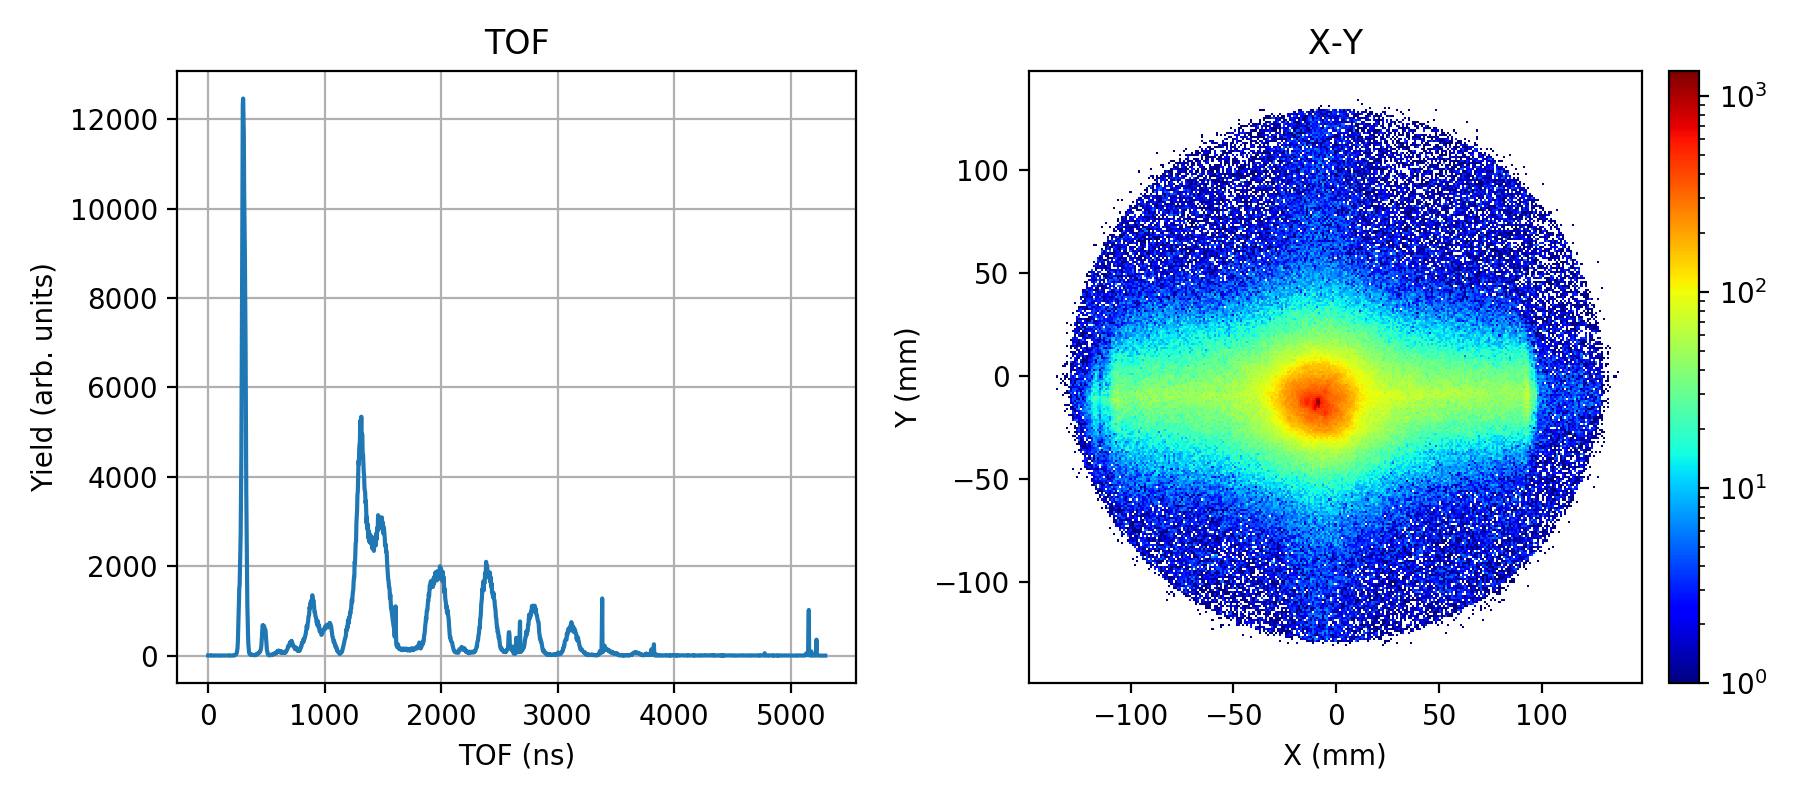

In [15]:
th2, _ = np.histogram(ts,tbins)
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(th1,th2)
plt.grid('on')
plt.title('TOF')
plt.xlabel('TOF (ns)')
plt.ylabel('Yield (arb. units)')

xy,_,_= np.histogram2d(xs,ys,bins=[xbins,xbins])
plt.subplot(122)
plot2d(xy,xh1,xh1,title='X-Y',xlabel='X (mm)',ylabel='Y (mm)',ast=1)

plt.tight_layout()

<IPython.core.display.Javascript object>


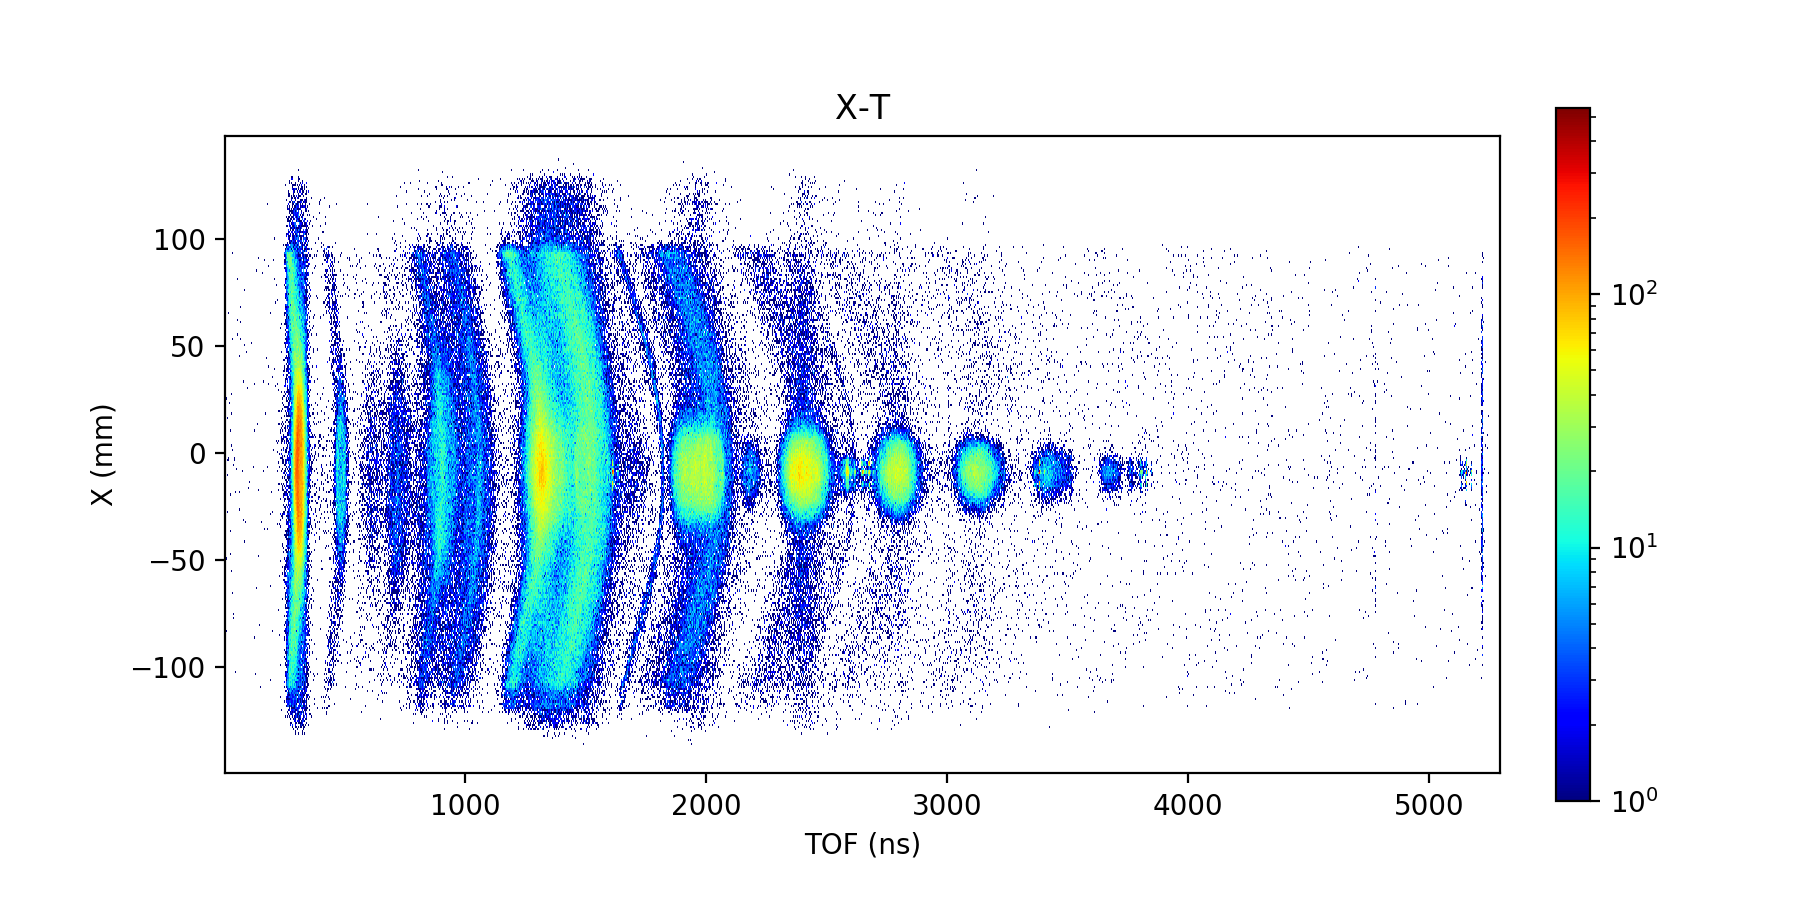

In [16]:
xt,_,_= np.histogram2d(ts,xs,bins=[tbins,xbins])
plot2d(xt,th1,xh1,title='X-T',xlabel='TOF (ns)',ylabel='X (mm)',ast=0.5,figsz = (9,4.5))


<IPython.core.display.Javascript object>


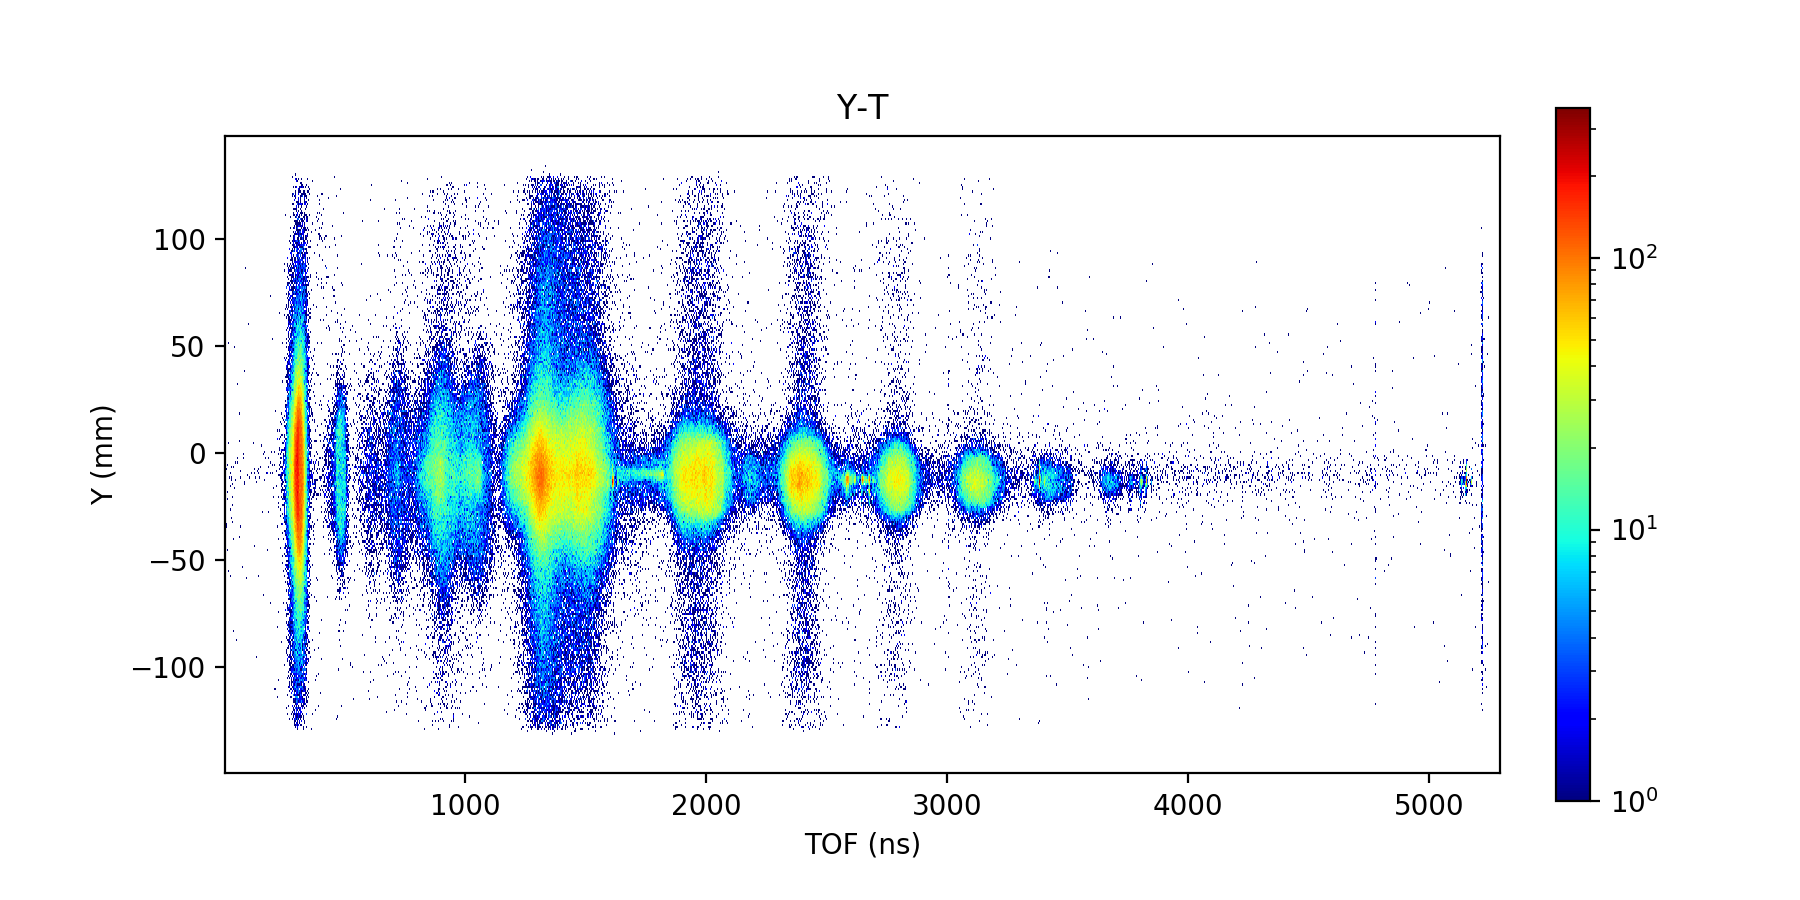

In [17]:
yt,_,_= np.histogram2d(ts,ys,bins=[tbins,xbins])
plot2d(yt,th1,xh1,title='Y-T',xlabel='TOF (ns)',ylabel='Y (mm)',ast=0.5,figsz = (9,4.5))

In [28]:
## idealy PiPiCo can be saved during preprocessing to avoid iterating through events one more time
ts0 = hits['t']
ppc = np.empty([0,2])
num_events = 50000 ## number of events to be used, can be larger
for i, t1 in enumerate(ts0):
    t1_ind = ~np.isnan(t1)
    t1 = sorted(t1[t1_ind])
    com = itertools.combinations(t1,2)
    com_arr = np.array([*com])
    if len(com_arr)>0:
        ppc = np.concatenate((ppc,com_arr),axis=0)
    if i%5000==0:
        print(i,'events processed .....')
    if i >num_events:
        break

0 events processed .....
5000 events processed .....
10000 events processed .....
15000 events processed .....
20000 events processed .....
25000 events processed .....
30000 events processed .....
35000 events processed .....
40000 events processed .....
45000 events processed .....
50000 events processed .....


<IPython.core.display.Javascript object>


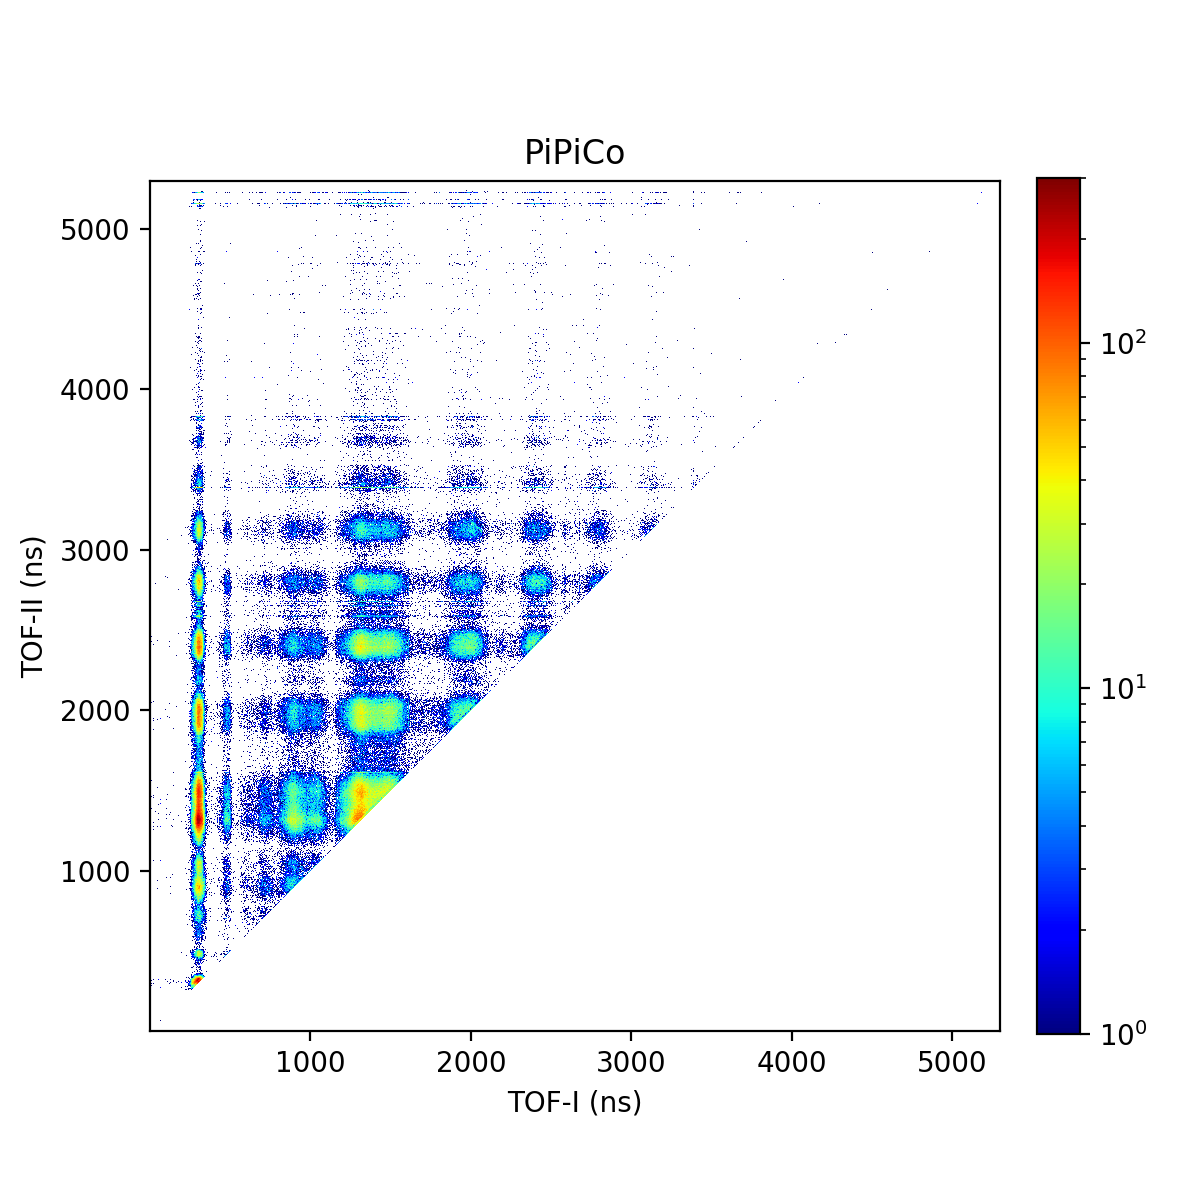

In [29]:
tt,_,_= np.histogram2d(ppc[:,0],ppc[:,1],bins=[tbins,tbins])
plot2d(tt,th1,th1,title='PiPiCo',xlabel='TOF-I (ns)',ylabel='TOF-II (ns)',ast=1,figsz = (6,6))